In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from typing import Tuple, Optional
import joblib

def load_data(file_path: str) -> pd.DataFrame:
    """
    Load data from a CSV file.
    
    Parameters:
        file_path (str): The path to the CSV file.
    
    Returns:
        pd.DataFrame: The loaded DataFrame.
    """
    return pd.read_csv(file_path)

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess data by selecting specific features.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
    
    Returns:
        pd.DataFrame: The preprocessed DataFrame.
    """
    features = ['hue', 'saturation', 'value', 'hsv_uniformity', 'compactness_score', 'Vertical Asymmetry_mean', 'Horizontal Asymmetry_mean']
    target = 'cancer'
    df = df[features + [target]]
    return df

def split_data(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    """
    Split data into training and testing sets.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
    
    Returns:
        Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]: 
        A tuple containing X_train, X_test, y_train, y_test.
    """
    X = df.drop('cancer', axis=1)
    y = df['cancer']
    return train_test_split(X, y, test_size=0.20, random_state=42)

def train(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, save_path: Optional[str] = None) -> pd.DataFrame:
    """
    Train models.
    
    Parameters:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training labels.
        X_test (pd.DataFrame): Testing features.
        y_test (pd.Series): Testing labels.
        save_path (Optional[str]): Path to save trained models (default=None).
    
    Returns:
        pd.DataFrame: DataFrame containing grid search results.
    """
    param_grid = {
        'n_estimators': [*range(1, 17), 50, 100, 1000],
        'max_depth': range(1, 21),
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2']
    }
    grid = ParameterGrid(param_grid)
    results = pd.DataFrame()

    for params in grid:
        model = RandomForestClassifier(**params)
        model.fit(X_train, y_train)
        accuracy = accuracy_score(y_test, model.predict(X_test))
        # print(f"Params: {params}, Accuracy: {accuracy:.4f}")
        params['accuracy'] = accuracy
        results = pd.concat([results, pd.DataFrame([params])], ignore_index=True)
        
        if save_path is not None:
            # Save model
            model_save_path = f"{save_path}model_{params}.pkl"
            joblib.dump(model, model_save_path)
    
    return results

In [15]:
file_path = 'features/features_original.csv'
data = load_data(file_path)
processed_data = preprocess_data(data)
X_train, X_test, y_train, y_test = split_data(processed_data)
    
results = train(X_train, y_train, X_test, y_test, save_path="models/")
best_result = results.iloc[results['accuracy'].idxmax()]
print(f"Best Model: {best_result.to_dict()}")

Best Model: {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 1, 'accuracy': 0.8076923076923077}


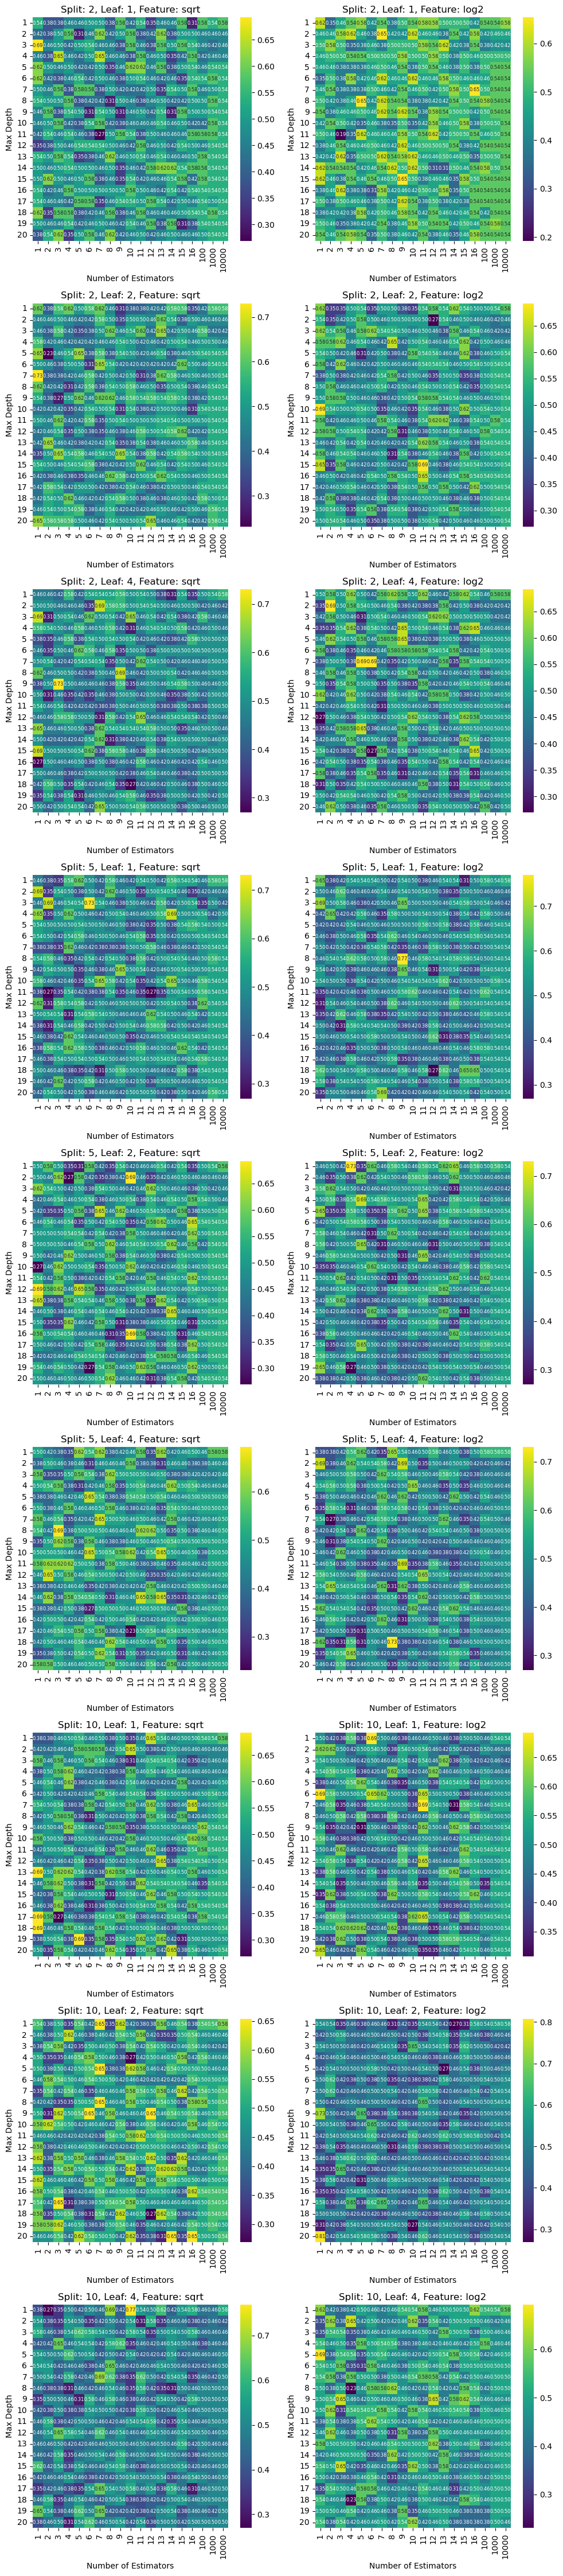

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_heatmaps(results, output_file="heatmaps.pdf"):
    # Filter unique parameters for grouping
    unique_splits = results['min_samples_split'].unique()
    unique_leaves = results['min_samples_leaf'].unique()
    unique_features = results['max_features'].unique()

    # Prepare subplot grid layout
    num_plots = len(unique_splits) * len(unique_leaves) * len(unique_features)
    num_cols = 2  # Define number of columns in grid layout
    num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate needed rows
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

    # Ensure axes is a 2D array for easier indexing
    if num_rows == 1:
        axes = np.array([axes])

    idx = 0
    for split in unique_splits:
        for leaf in unique_leaves:
            for feature in unique_features:
                ax = axes[idx // num_cols, idx % num_cols]
                # Filter results for specific parameters
                subset = results[(results['min_samples_split'] == split) &
                                 (results['min_samples_leaf'] == leaf) &
                                 (results['max_features'] == feature)]
                # Pivot table for heatmap
                pivot_table = subset.pivot_table(values='accuracy', index='max_depth', columns='n_estimators')
                sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap='viridis', ax=ax, annot_kws={"fontsize": 6})
                ax.set_title(f'Split: {split}, Leaf: {leaf}, Feature: {feature}')
                ax.set_xlabel('Number of Estimators')
                ax.set_ylabel('Max Depth')
                idx += 1

    # Adjust layout
    plt.tight_layout()
    
    # Save the figure as a PDF
    plt.savefig(output_file)
    
    # Show the plot
    plt.show()

plot_heatmaps(results, output_file="heatmaps.pdf")

In [17]:
def print_top_10_models(results):
    # Sort results by accuracy in descending order
    top_results = results.sort_values(by='accuracy', ascending=False).head(10)
    # Print the top 10 results
    print("Top 10 Models:")
    print(top_results)

print_top_10_models(results)

Top 10 Models:
      max_depth max_features  min_samples_leaf  min_samples_split  \
6764         20         log2                 2                 10   
161           1         sqrt                 4                 10   
2592          8         log2                 1                  5   
2109          7         sqrt                 2                  2   
2852          9         sqrt                 4                  2   
708           3         sqrt                 1                  5   
6125         18         log2                 4                  5   
3002          9         log2                 2                 10   
250           1         log2                 2                  5   
3306         10         log2                 2                  2   

      n_estimators  accuracy  
6764             1  0.807692  
161             10  0.769231  
2592             9  0.769231  
2109             1  0.730769  
2852             3  0.730769  
708              6  0.730769  
6125    

In [16]:
# Save the results DataFrame to a CSV file
results.to_csv("results.csv", index=False)